## TVLT Sentiment Analysis

This notebook demonstrates how to use TVLT for Sentiment Analysis on Video-Audio inputs. (MOSEI dataset)

### Load model for sentiment analysis

In [35]:
from demos import MOSEI_sentiment_model

model = MOSEI_sentiment_model()

# Be default, the model weight will be automatically downloaded into ~/.cache/huggingface/hub/models--TVLT--models/blobs
# The symbol link of the model will be in ~/.cache/huggingface/hub/models--TVLT--models/snapshots/5f9684296bcd0389ce6af252487f8b82e9170f2b/[the_checkpoint_symbol_link] -> ../../blobs/[the_actual_model_file]
# This is automatically handled by huggingface hub.

### Load sample data

In [36]:
from model.data.datasets.rawvideo_utils import load_audio, load_video, load_video_audio

video_path = 'demo_samples/MOSEI/K0m1tO3Ybyc_2.mp4' # You can specify your own video file here
audio_path = 'demo_samples/MOSEI/K0m1tO3Ybyc_2.wav' # You can specify your own audio file here
video = load_video(video_path, num_frames=8)
audio = load_audio(audio_path, sr=44100)

# or if your input video file already has an audio channel
# video_path = 'demo_samples/MOSEI/K0m1tO3Ybyc_2.mp4'
# video, audio = load_video_audio(video_path, num_frames=8, sr=44100, timestamp=timestamp)

  warnings.warn(



### Inference

In [37]:
encoder_last_hidden_outputs, *_ = model(video=video, audio=audio)
sentiment_score = model.classifier(encoder_last_hidden_outputs).squeeze().data.numpy()

--------------------------
sentiment intensity: 0.407
--------------------------

Sample Display


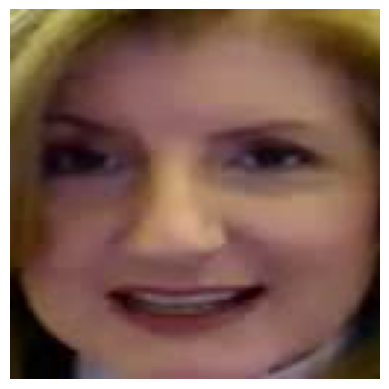

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from model.data.datasets.rawvideo_utils import load_video_raw

print('--------------------------')
print('sentiment intensity:', np.round(sentiment_score, 3))

print('--------------------------')
print()
print('Sample Display')
plt.axis('off')
plt.imshow(load_video_raw(video_path, 3)[0])
plt.show()


import IPython

IPython.display.Audio(audio_path)

### Note on shape of the tensor

* Dimension of input video tensor: (batch_size, number_of_frames, rgb_channel, width, height)  
* Dimension of input audio tensor: (batch_size, number_of_audio_channels, time, spectrogram)

See the actual size of the tensor below.

In [39]:
print(video.size())   # 1, 8, 3, 224, 224
print(audio.size())   # 1, 1, 432, 128

torch.Size([1, 8, 3, 224, 224])
torch.Size([1, 1, 432, 128])


We encoder the input video and audio using the transformer.

See the size of the hidden outputs below.

In [40]:
encoder_last_hidden_outputs, *_ = model(video=video, audio=audio)
print(encoder_last_hidden_outputs.size())

torch.Size([1, 1785, 768])


We can see that we got a total number of **1785** features with dimension size being 768 (the hidden output size of TVLT encoder).

**How is 1785 added up?**

We split the input video frames into $16 \times 16$-sized patches and split input audio spectrogram into $16 \times 16$-sized patches.  

Given that we have $8$ frames of $224 \times 224$-images and the audio spectrogram is $432 \times 128$, we will have $8 \times \frac{224}{16} \times \frac{224}{16} = 1568$ video patches and $\frac{432}{16} \times \frac{128}{16} = 216 $ audio patches.

We apply transformer on each patch and then append a $[CLS]$ token at the beginning. That gives us a total number of $1 + 1568 + 216 = 1785$ features.

Finally, we apply MLP head on the first $[CLS]$ token. See the code below.

In [41]:
sentiment_score_t = model.classifier(encoder_last_hidden_outputs)
print(sentiment_score_t)  # print the output sentiment intensity for the input.


tensor([[0.4072]], grad_fn=<AddmmBackward0>)
